### Basic Imports

In [105]:
import nbimporter
from typing import Dict, Tuple, List
import numpy as np
from tqdm import tqdm

### Env Vars

In [106]:
QUBITS_NUM = 4 
N = 16
K = 4
NUM_SHOTS = 1024
NUM_ITERATIONS = 50

w_vector = np.asarray([4,3,2,1])

### Simulator Backend

In [107]:
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals

seed = 50
algorithm_globals.random_seed = seed

simulator_backend = Aer.get_backend('qasm_simulator')

### BFGS Optimizer

In [108]:
from scipy.optimize import minimize

### K input states (computational basis)

In [109]:
from utiles import *

In [110]:
input_states = get_first_k_eigenvectors_from_n_computational_basis(K, N)

### Ansatz State

In [111]:
from ansatz_circuit_item2 import get_full_variational_quantum_circuit

In [112]:
init_circuit_params = {
    "thetas": np.random.uniform(low=0, high=2*np.pi, size=8),
    "phis": np.random.uniform(low=0, high=2*np.pi, size=4),
    "D1": 2,
    "D2": 8
}

In [113]:
def prepare_circuit_params(thetas) -> Dict:
     return {
    "thetas": thetas[4:],
    "phis": thetas[:4],
    "D1": 2,
    "D2": 8
     }

In [114]:
def get_ansatz_state(circuit_params, input_state):
    circuit_params_with_input_state = {**circuit_params, "input_state": input_state}
    return get_full_variational_quantum_circuit(**circuit_params_with_input_state)

## Expectation Value

### convert hamiltonian to pauli strings

In [115]:
def transfrom_hamiltonian_into_pauli_strings(hamiltonian) -> List:
    pauli_operators = hamiltonian.to_pauli_op().settings['oplist']
    pauli_coeffs = list(map(lambda pauli_operator: pauli_operator.coeff, pauli_operators))
    pauli_strings = list(map(lambda pauli_operator: pauli_operator.primitive, pauli_operators))
    return pauli_coeffs, pauli_strings

### pauli string reduction to sigma_z's

In [116]:
from qiskit.circuit.library.standard_gates import HGate, SGate
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

In [117]:
reducing_to_pauli_z_mapping = {
    'I': 'I',
    'Z': 'Z',
    'X': 'Z',
    'Y': 'Z'
} 

In [118]:
def reduce_pauli_matrixes_into_sigma_z(pauli_string) -> str:
    reduced_pauli_string = ""
    for matrix_index in range(QUBITS_NUM):
        pauli_matrix = str(pauli_string[matrix_index])
        reduced_pauli_matrix = reducing_to_pauli_z_mapping[pauli_matrix]
        reduced_pauli_string = reduced_pauli_matrix + reduced_pauli_string
    
    return reduced_pauli_string

In [119]:
def add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string, quantum_circuit):
    quantum_registers = QuantumRegister(QUBITS_NUM, name="qubit")
    additional_circuit_layer = QuantumCircuit(quantum_registers)
    
    for quantum_register_index, pauli_matrix in enumerate(pauli_string):
        if pauli_matrix == "X":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
        if pauli_string == "Y":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
            additional_circuit_layer.append(SGate(), [quantum_registers[quantum_register_index]])
                
    extended_quantum_circuit = quantum_circuit.compose(additional_circuit_layer)
    return extended_quantum_circuit

### probabilities distribution

In [120]:
def get_probability_distribution(counts: Dict) -> Dict:
    proba_distribution = {state: (count / NUM_SHOTS) for state, count in counts.items()}
    return proba_distribution

def calculate_probabilities_of_measurments_in_computational_basis(quantum_state_circuit) -> Dict:
    quantum_state_circuit.measure_all()
    
    transpiled_quantum_state_circuit = transpile(quantum_state_circuit, simulator_backend) 
    Qobj = assemble(transpiled_quantum_state_circuit)
    result = simulator_backend.run(Qobj).result()
    counts = result.get_counts(quantum_state_circuit)
    
    return get_probability_distribution(counts)

### Expectation value from probabilities

In [121]:
def sort_probas_dict_by_qubits_string_keys(proba_distribution: Dict) -> Dict:
    return dict(sorted(proba_distribution.items()))

def reset_power_of_minus_1(power_of_minus_1):
    power_of_minus_1 = 0
    return power_of_minus_1

def convert_pauli_string_into_str(pauli_string) -> str:
    return str(pauli_string)

def calculate_expectation_value_of_pauli_string_by_measurments_probas(pauli_string, ansatz_circuit):
    pauli_string_expectation_value = 0
    power_of_minus_1 = 0
    
    pauli_string_str = convert_pauli_string_into_str(pauli_string)
    extended_ansatz_circuit = add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string_str, ansatz_circuit)
    probas_distribution = calculate_probabilities_of_measurments_in_computational_basis(extended_ansatz_circuit)
    
    reduced_pauli_string = reduce_pauli_matrixes_into_sigma_z(pauli_string)
    sorted_probas_distribuition = sort_probas_dict_by_qubits_string_keys(probas_distribution)
    for qubits_string, proba in sorted_probas_distribuition.items():
        for string_index in range(QUBITS_NUM):
            if(str(qubits_string[string_index])=="1" and str(pauli_string[string_index])=="Z"):
                power_of_minus_1 += 1
            
        pauli_string_expectation_value += pow(-1, power_of_minus_1)*proba
        power_of_minus_1 = reset_power_of_minus_1(power_of_minus_1)
        
    return pauli_string_expectation_value

In [122]:
def get_expectation_value(ansatz_circuit, pauli_coeffs, pauli_strings):
    total_expection_value = 0
    
    for pauli_coeff, pauli_string in zip(pauli_coeffs, pauli_strings):
        total_expection_value += pauli_coeff*calculate_expectation_value_of_pauli_string_by_measurments_probas(
                                                                                    pauli_string, ansatz_circuit)
    
    return total_expection_value

## Objective Function

In [123]:
from qiskit import assemble, transpile

def cost_function(thetas, hamiltonian):
    L_w = 0
    circuit_params = prepare_circuit_params(thetas)
    computational_eigenvectors = get_first_k_eigenvectors_from_n_computational_basis(K, N)
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(LiH_molecule_4_qubits)
    
    for j in tqdm(range(K)):
        ansatz_state = get_ansatz_state(circuit_params, computational_eigenvectors[j])
        approximated_energy = get_expectation_value(ansatz_state, pauli_coeffs, pauli_strings)
        insert_approximated_energy_to_list_of_all_approximated_energies(
            approximated_energies_dict["approximated_eneriges_"+str(j)], approximated_energy)
        L_w += w_vector[j]*approximated_energy
        
    return L_w

### Optimization

In [124]:
def get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian):
    initial_thetas = np.random.uniform(low=0, high=360, size=12)
    optimizer_result = minimize(
                            cost_function,
                            x0=initial_thetas,
                            args=(hamiltonian),
                            method="COBYLA",
                            options={"maxiter":NUM_ITERATIONS})
    optimal_thetas = prepare_circuit_params(optimizer_result.x)
    
    return optimal_thetas

In [125]:
def get_approximated_k_eigenvalues_of_hamiltonian(hamiltonian):
    approximated_k_eigenvalues = []
    optimal_thetas = get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian)
    computational_eigenvectors = get_first_k_eigenvectors_from_n_computational_basis(K, N)
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    for eigenvalue_index, eigenvector in enumerate(computational_eigenvectors):
        optimal_ansatz_state = get_ansatz_state(optimal_thetas, eigenvector)
        approximated_eigenvalue = get_expectation_value(optimal_ansatz_state, pauli_coeffs, pauli_strings)
        approximated_k_eigenvalues.append(approximated_eigenvalue)

    return approximated_k_eigenvalues

## Comparsion

In [126]:
from numpy import linalg as LA
from statistics import mean

def get_mean_approximation_error(exact_k_eigenvalues, approximated_k_eigenvalues):
    approximated_errors = []
    for exact_eigenvalue, approximated_eigenvalue in zip(exact_k_eigenvalues, approximated_k_eigenvalues):
        approximated_errors.append(abs(abs(exact_eigenvalue)-abs(approximated_eigenvalue))/abs(exact_eigenvalue))
        
    return mean(approximated_errors)

In [127]:
def get_exact_k_eigenvalues_of_hamiltonian(hamiltonian, k):
    eigenvalues = LA.eig(hamiltonian.to_matrix())[0]
    
    return sorted(eigenvalues)[:k]

In [128]:
def compare_exact_and_approximated_eigenvectors(hamiltonian, approximated_k_eigenvalues):
    exact_k_eigenvalues = get_exact_k_eigenvalues_of_hamiltonian(hamiltonian, K)
    print("Exact K Eigenvalues:")
    print(exact_k_eigenvalues)
    
    print("\nApproximated K Eigenvalues:")
    print(sorted(approximated_k_eigenvalues))

    print("\nMean Approximation error:")
    print(get_mean_approximation_error(exact_k_eigenvalues, sorted(approximated_k_eigenvalues)))

## Visualization

In [129]:
approximated_energies_dict = { "approximated_eneriges_0": [],
"approximated_eneriges_1":[],
"approximated_eneriges_2": [],
"approximated_eneriges_3": []}

In [130]:
def initialize_approximated_energies_dict():
    return { "approximated_eneriges_0": [],
        "approximated_eneriges_1":[],
        "approximated_eneriges_2": [],
        "approximated_eneriges_3": []}

In [131]:
def insert_approximated_energy_to_list_of_all_approximated_energies(approximated_energies_list, energy):
    approximated_energies_list.append(energy)

In [132]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_convergence_of_optimization_process(approximated_energies, hamiltonian, margin=0.02):
    plt.title("convergence of optimization process to the exact eigenvalue")
    plt.margins(0,margin)
    base_colors_list = list(mcolors.BASE_COLORS.keys())
    
    exact_k_eigenvalues = get_exact_k_eigenvalues_of_hamiltonian(hamiltonian, K)
    print(exact_k_eigenvalues)
    for energy_level, eigenvalue in enumerate(exact_k_eigenvalues):
        energy_level_name = "E_{0}".format(str(energy_level))
        
        plt.axhline(y = eigenvalue, 
                    color = base_colors_list[energy_level], 
                    linestyle = 'dotted', label=energy_level_name)
        plt.plot(approximated_energies["approximated_eneriges_{0}".format(str(energy_level))],
                 color = base_colors_list[energy_level], 
                 label="Weighted_SSVQE({0})".format(energy_level_name))
    
#     plt.plot(approximated_energies["approximated_eneriges_0"])
#     plt.plot(approximated_energies["approximated_eneriges_1"])
#     plt.plot(approximated_energies["approximated_eneriges_2"])
#     plt.plot(approximated_energies["approximated_eneriges_3"])
    
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
def plot_fidelity():
    plt.plot(LiH_approximated_energies)
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")

## LiH Molecule 4 qubits

In [133]:
from qiskit.opflow import X, Z, Y, I, H, S

In [134]:
LiH_molecule_4_qubits = -7.49894690201071*(I^I^I^I) + \
-0.0029329964409502266*(X^X^Y^Y) + \
0.0029329964409502266*(X^Y^Y^X) + \
0.01291078027311749*(X^Z^X^I) + \
-0.0013743761078958677*(X^Z^X^Z) + \
0.011536413200774975*(X^I^X^I) + \
0.0029329964409502266*(Y^X^X^Y) + \
-0.0029329964409502266*(Y^Y^X^X) + \
0.01291078027311749*(Y^Z^Y^I) + \
-0.0013743761078958677*(Y^Z^Y^Z) + \
0.011536413200774975*(Y^I^Y^I) + \
0.16199475388004184*(Z^I^I^I) + \
0.011536413200774975*(Z^X^Z^X) + \
0.011536413200774975*(Z^Y^Z^Y) + \
0.12444770133137588*(Z^Z^I^I) + \
0.054130445793298836*(Z^I^Z^I) + \
0.05706344223424907*(Z^I^I^Z) + \
0.012910780273117487*(I^X^Z^X) + \
-0.0013743761078958677*(I^X^I^X) + \
0.012910780273117487*(I^Y^Z^Y) + \
-0.0013743761078958677*(I^Y^I^Y) + \
0.16199475388004186*(I^Z^I^I) + \
0.05706344223424907*(I^Z^Z^I) + \
0.054130445793298836*(I^Z^I^Z) + \
-0.013243698330265966*(I^I^Z^I) + \
0.08479609543670981*(I^I^Z^Z) + \
-0.013243698330265952*(I^I^I^Z)

In [135]:
%%time
LiH_approximated_k_eigenvalues = get_approximated_k_eigenvalues_of_hamiltonian(LiH_molecule_4_qubits)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:15<00:00, 18.99s/it]


CPU times: total: 30min 34s
Wall time: 1h 1min 34s


In [136]:
compare_exact_and_approximated_eigenvectors(LiH_molecule_4_qubits, LiH_approximated_k_eigenvalues)

Exact K Eigenvalues:
[(-7.862773163027979+0j), (-7.7833962082865185+0j), (-7.783396208286518+0j), (-7.7140566916607005+0j)]

Approximated K Eigenvalues:
[-7.580881155465277, -7.518562261817138, -7.502616103528626, -7.3777513421987795]

Mean Approximation error:
0.03738691156820354


In [137]:
print(approximated_energies_dict)
approximated_energies_dict = initialize_approximated_energies_dict()

{'approximated_eneriges_0': [-7.443763256904104, -7.4002130802981165, -7.402247491880844, -7.470848596022202, -7.45320004578142, -7.2037442823809394, -7.606622032604259, -7.432350599744895, -7.432495103535102, -7.141159809219269, -7.34603922757036, -7.476135398795488, -7.280043003574207, -7.4614181224914295, -7.407924717612185, -7.461586578652535, -7.525445976535891, -7.422114431402694, -7.401649526037618, -7.488021953946464, -7.47896570893905, -7.462685937161847, -7.454120832230556, -7.436292572707697, -7.480688115871342, -7.515063846777348, -7.477177021961932, -7.391244710949009, -7.471217858315684, -7.503242588552382, -7.471439257727218, -7.44505573833778, -7.418285185624123, -7.466695823049642, -7.4771052531993325, -7.4637738318283535, -7.520776558858023, -7.526230791574609, -7.533608947411593, -7.503004948009757, -7.519724331102011, -7.493384913528219, -7.485478644775202, -7.516510223399673, -7.503475090881356, -7.494010354458551, -7.510090310795372, -7.526632388070386, -7.4921608

[(-7.862773163027979+0j), (-7.7833962082865185+0j), (-7.783396208286518+0j), (-7.7140566916607005+0j)]


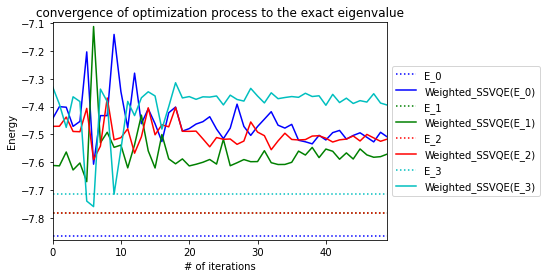

In [149]:
LiH_approximated_energies = {'approximated_eneriges_0': [-7.443763256904104, -7.4002130802981165, -7.402247491880844, -7.470848596022202, -7.45320004578142, -7.2037442823809394, -7.606622032604259, -7.432350599744895, -7.432495103535102, -7.141159809219269, -7.34603922757036, -7.476135398795488, -7.280043003574207, -7.4614181224914295, -7.407924717612185, -7.461586578652535, -7.525445976535891, -7.422114431402694, -7.401649526037618, -7.488021953946464, -7.47896570893905, -7.462685937161847, -7.454120832230556, -7.436292572707697, -7.480688115871342, -7.515063846777348, -7.477177021961932, -7.391244710949009, -7.471217858315684, -7.503242588552382, -7.471439257727218, -7.44505573833778, -7.418285185624123, -7.466695823049642, -7.4771052531993325, -7.4637738318283535, -7.520776558858023, -7.526230791574609, -7.533608947411593, -7.503004948009757, -7.519724331102011, -7.493384913528219, -7.485478644775202, -7.516510223399673, -7.503475090881356, -7.494010354458551, -7.510090310795372, -7.526632388070386, -7.492160858734219, -7.5090846022988345], 'approximated_eneriges_1': [-7.611160770738447, -7.612537039823402, -7.5628667736575075, -7.627321643310454, -7.602218901158253, -7.669321267055824, -7.112869137843162, -7.529831878035033, -7.492031424566759, -7.546144927687019, -7.5380518543846815, -7.619806507952486, -7.536960192278364, -7.430594135829916, -7.558781662996708, -7.620192075334588, -7.500080654402885, -7.5874392595184466, -7.60518715593763, -7.587653509223957, -7.612775269021471, -7.6068484660945295, -7.599678769877363, -7.589714279771383, -7.60619548365883, -7.51735676728312, -7.612125836144872, -7.6014638647121675, -7.5899647846917055, -7.5976032888517775, -7.597212073112908, -7.558188737021209, -7.601200874808052, -7.607713345897209, -7.607499093171809, -7.599792654361252, -7.5596730670773855, -7.573728870000363, -7.546383632358012, -7.583001966857374, -7.5523102781572735, -7.560199542695961, -7.588780755315564, -7.566078651167328, -7.5879779290873905, -7.551861316141719, -7.573269260993632, -7.5817304433034804, -7.579569386092089, -7.570120795581553], 'approximated_eneriges_2': [-7.470829844981112, -7.470523575311227, -7.437547474097366, -7.489185208098881, -7.490140854087586, -7.406399694105737, -7.590301545017305, -7.541698353920802, -7.3691554663088015, -7.5191215141999335, -7.5115133084041545, -7.479635969058671, -7.567154091041735, -7.50831667284109, -7.404328307409327, -7.5010681837274165, -7.4650688490182455, -7.472575860441914, -7.402811603611692, -7.488550998068402, -7.488801074870055, -7.487994212250475, -7.515666333417201, -7.544214178703916, -7.510926968697341, -7.5173523503867195, -7.516193644717367, -7.53534000298624, -7.523519316290358, -7.455126696410415, -7.491381392393936, -7.504298259865865, -7.554652346024801, -7.523103712442472, -7.4955202720183, -7.517862423002627, -7.519654460714506, -7.518381698117194, -7.505702129067322, -7.504489391632537, -7.513392952340638, -7.5270772264781485, -7.519299542624053, -7.516485116618228, -7.50529569871512, -7.523333441799501, -7.499747575849092, -7.512325163721414, -7.52439763900249, -7.516395718429318], 'approximated_eneriges_3': [-7.32849500423405, -7.391564768264744, -7.474600394267608, -7.364808119047038, -7.381820772708144, -7.738911447566172, -7.758703374786833, -7.337171319897428, -7.381997666733045, -7.7142353175373115, -7.553174001897375, -7.381334761150993, -7.432289783474271, -7.368363081328347, -7.3468625031342345, -7.361828638208896, -7.480664471801326, -7.400110228803251, -7.3144431418222435, -7.368928231722106, -7.364078865897079, -7.373915189743662, -7.364944693985124, -7.3659051775080195, -7.361913922683342, -7.393984696256876, -7.358970234887909, -7.374457680841522, -7.380263158291077, -7.334590298526401, -7.362071851140452, -7.386812482151001, -7.350540699194575, -7.371636446671611, -7.367436744048734, -7.364018994060641, -7.366669879511723, -7.352155755509138, -7.36382240372502, -7.361211381137372, -7.395275852423786, -7.356090854960467, -7.385525123953955, -7.369782537122054, -7.388817786814771, -7.378669588844872, -7.38373310976381, -7.353810063874061, -7.387305671775982, -7.39466794423844]}
plot_convergence_of_optimization_process(LiH_approximated_energies, LiH_molecule_4_qubits, margin=0.02)

## H2 Molecule 4 qubits

In [139]:
H2_molecule_Hamiltonian_4_qubits =  -0.8105479805373279 * (I^I^I^I) \
                                    + 0.1721839326191554 * (I^I^I^Z) \
                                    - 0.22575349222402372 * (I^I^Z^I) \
                                    + 0.17218393261915543 * (I^Z^I^I) \
                                    - 0.2257534922240237 * (Z^I^I^I) \
                                    + 0.12091263261776627 * (I^I^Z^Z) \
                                    + 0.16892753870087907 * (I^Z^I^Z) \
                                    + 0.045232799946057826 * (Y^Y^Y^Y) \
                                    + 0.045232799946057826 * (X^X^Y^Y) \
                                    + 0.045232799946057826 * (Y^Y^X^X) \
                                    + 0.045232799946057826 * (X^X^X^X) \
                                    + 0.1661454325638241 * (Z^I^I^Z) \
                                    + 0.1661454325638241 * (I^Z^Z^I) \
                                    + 0.17464343068300453 * (Z^I^Z^I) \
                                    + 0.12091263261776627 * (Z^Z^I^I)

In [140]:
%%time
H2_approximated_k_eigenvalues = get_approximated_k_eigenvalues_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:29<00:00, 22.30s/it]


CPU times: total: 29min 15s
Wall time: 1h 11min 28s


In [141]:
compare_exact_and_approximated_eigenvectors(H2_molecule_Hamiltonian_4_qubits, H2_approximated_k_eigenvalues)

Exact K Eigenvalues:
[(-1.8572750302023793+0j), (-1.25633907300325+0j), (-1.2563390730032498+0j), (-1.2445845498133272+0j)]

Approximated K Eigenvalues:
[-1.5504114559498734, -1.017971022939125, -0.9316803438045633, -0.8308607910407838]

Mean Approximation error:
0.23644759631911413


In [142]:
print(approximated_energies_dict)
approximated_energies_dict = initialize_approximated_energies_dict()

{'approximated_eneriges_0': [-7.6847981551656215, -7.69669203350899, -7.695360282155182, -7.678547396735197, -7.682475520277694, -7.6665142799074735, -7.628511929237866, -7.727019079759623, -7.674672621892967, -7.782410750059304, -7.782640995023298, -7.774731391845236, -7.820098880570926, -7.644963955279764, -7.765933104421869, -7.689259899346986, -7.75838188322518, -7.7617232185924685, -7.6749058485455, -7.7606516385721775, -7.628823093333026, -7.778442627599486, -7.745777242153594, -7.753227986202937, -7.784556444100247, -7.756083187584806, -7.714476381527707, -7.780522704585265, -7.776979399600117, -7.782311933837449, -7.7842922352561335, -7.7870034099757515, -7.778992899075237, -7.787348917202359, -7.781744204782898, -7.789211430733308, -7.7871397501264985, -7.784088445887376, -7.793805473659068, -7.79346880686618, -7.786308107923922, -7.7925468325707765, -7.793338173915457, -7.78652494500572, -7.790090500177619, -7.792533180308775, -7.7962537918904715, -7.78963405481515, -7.786085

[(-1.8572750302023793+0j), (-1.25633907300325+0j), (-1.2563390730032498+0j), (-1.2445845498133272+0j)]


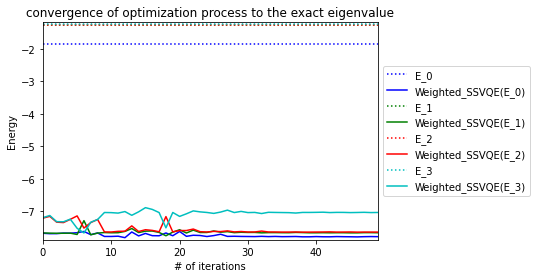

In [154]:
H2_approximated_energies = {'approximated_eneriges_0': [-7.6847981551656215, -7.69669203350899, -7.695360282155182, -7.678547396735197, -7.682475520277694, -7.6665142799074735, -7.628511929237866, -7.727019079759623, -7.674672621892967, -7.782410750059304, -7.782640995023298, -7.774731391845236, -7.820098880570926, -7.644963955279764, -7.765933104421869, -7.689259899346986, -7.75838188322518, -7.7617232185924685, -7.6749058485455, -7.7606516385721775, -7.628823093333026, -7.778442627599486, -7.745777242153594, -7.753227986202937, -7.784556444100247, -7.756083187584806, -7.714476381527707, -7.780522704585265, -7.776979399600117, -7.782311933837449, -7.7842922352561335, -7.7870034099757515, -7.778992899075237, -7.787348917202359, -7.781744204782898, -7.789211430733308, -7.7871397501264985, -7.784088445887376, -7.793805473659068, -7.79346880686618, -7.786308107923922, -7.7925468325707765, -7.793338173915457, -7.78652494500572, -7.790090500177619, -7.792533180308775, -7.7962537918904715, -7.78963405481515, -7.786085398062213, -7.7891853374630635], 'approximated_eneriges_1': [-7.674684523604055, -7.680764074432957, -7.684992567218362, -7.683800571677806, -7.680390184089667, -7.721622516127985, -7.295633734656554, -7.7311487161990256, -7.678587133102517, -7.662425555106433, -7.669138289334058, -7.6673461427248775, -7.626942993490443, -7.538153577774583, -7.662429920440635, -7.619523577002202, -7.614356108241046, -7.658931116094572, -7.761466767269052, -7.64876243086473, -7.575843530150479, -7.675840508678627, -7.587039305802285, -7.66134535231588, -7.659686693231967, -7.6135464123687475, -7.651463803918251, -7.634151979073155, -7.665419894321144, -7.653707767256248, -7.659251797898335, -7.658200706731602, -7.671972673195233, -7.66434999274741, -7.663813235960182, -7.666611902147287, -7.667328389333765, -7.658213410128788, -7.663109239237157, -7.669688709053952, -7.669483352101843, -7.666970692695458, -7.67011145442623, -7.66774490260206, -7.66767261347493, -7.671932371682364, -7.671697879258323, -7.664936996622855, -7.665002841620933, -7.668432858833779], 'approximated_eneriges_2': [-7.216994389513745, -7.162295345496143, -7.340953879090269, -7.354575085834582, -7.25564377642011, -7.148940094695811, -7.524402673550271, -7.354347811404502, -7.25889495057094, -7.643589020627088, -7.644947961476648, -7.625158816558789, -7.620703327132717, -7.45620769838637, -7.630870366832682, -7.575290709380177, -7.596165182631779, -7.637811242834557, -7.170274298321406, -7.641715648367393, -7.601007658607277, -7.599962246378673, -7.554443833932802, -7.635475447591654, -7.64486017630937, -7.626536753201153, -7.6322795435642625, -7.610659904945782, -7.642214540537407, -7.630361126826373, -7.645346880047898, -7.6443043653096305, -7.616965316828286, -7.644233130202644, -7.64564265540827, -7.648497631150577, -7.647931469579165, -7.645272451577426, -7.650160805708954, -7.64876250969817, -7.646823091092999, -7.645297203651874, -7.641287946379679, -7.648284082427012, -7.6468976982996475, -7.6442778318847076, -7.649731833380351, -7.647619040578347, -7.648140904559129, -7.647936421498813], 'approximated_eneriges_3': [-7.202290172665147, -7.136542775453234, -7.32557094169548, -7.3304047498628275, -7.250215528560754, -7.530121383747615, -7.674756284215522, -7.3437821085023725, -7.25926128948872, -7.043725550448698, -7.048032766005656, -7.062091983030029, -7.015079505078198, -7.130094283026538, -7.023198238540297, -6.894206716999318, -6.948244787472701, -7.045666589563991, -7.516441009890359, -7.043138953607762, -7.164113379397319, -7.083629601908816, -6.994407404756581, -7.024569950050662, -7.042675844714379, -7.071398804304009, -7.030579249445848, -6.970942611477129, -7.0452067433138, -7.009655723846796, -7.0465525569622045, -7.041138823294234, -7.0758293298141, -7.037825997609188, -7.042134113140199, -7.045247103049186, -7.04832718431786, -7.060394271726066, -7.041607839469861, -7.04191968859915, -7.038852427210924, -7.034303963384438, -7.046001232407491, -7.0401609547447235, -7.040921144894931, -7.04670117664207, -7.043097516559149, -7.038106821967233, -7.045959853355035, -7.042930913127023]}
plot_convergence_of_optimization_process(H2_approximated_energies, H2_molecule_Hamiltonian_4_qubits,margin=0.01)

##  Transverse Ising Model 4 qubits

In [144]:
transverse_ising_4_qubits = 0.0 * (I^I^I^I) \
    + 0.8398088405253477 * (X^I^I^I) \
    + 0.7989496312070936 * (I^X^I^I) \
    + 0.38189710487113193 * (Z^Z^I^I) \
    + 0.057753122422666725 * (I^I^X^I) \
    + 0.5633292636970458 * (Z^I^Z^I) \
    + 0.3152740621483513 * (I^Z^Z^I) \
    + 0.07209487981989715 * (I^I^I^X) \
    + 0.17892334004292654 * (Z^I^I^Z) \
    + 0.2273896497668042 * (I^Z^I^Z) \
    + 0.09762902934216211 * (I^I^Z^Z)

In [145]:
%%time
TI_approximated_k_eigenvalues = get_approximated_k_eigenvalues_of_hamiltonian(transverse_ising_4_qubits)

100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [7:52:42<00:00, 7090.59s/it]


CPU times: total: 29min 13s
Wall time: 9h 31min 14s


In [146]:
compare_exact_and_approximated_eigenvectors(transverse_ising_4_qubits, TI_approximated_k_eigenvalues)

Exact K Eigenvalues:
[(-1.9994855800333675+0j), (-1.9080638482930956+0j), (-1.8497137109270194+0j), (-1.7583827504312988+0j)]

Approximated K Eigenvalues:
[1.4369662278231317, 1.5794900443385647, 1.5847315826298767, 2.043222110830405]

Mean Approximation error:
0.18969497896859364


In [147]:
print(approximated_energies_dict)
approximated_energies_dict = initialize_approximated_energies_dict()

{'approximated_eneriges_0': [-7.589752024122858, -7.613360553742977, -7.6190283377699295, -7.606452381315795, -7.623841264856606, -7.494521829539001, -7.646521400209204, -7.497441846730476, -7.679252378794595, -7.568306667439035, -7.635326747625471, -7.581974996633829, -7.6029476683468165, -7.629264364655602, -7.622068391999914, -7.639909424564434, -7.658080921293223, -7.6610216888186935, -7.654527411413256, -7.66008477955216, -7.7547150031040335, -7.7564360961248395, -7.7211692300067325, -7.740308604020784, -7.600566578864045, -7.745346804765525, -7.7462796221068615, -7.751641127972047, -7.731226373852388, -7.759764904228919, -7.738323394248081, -7.75008559994191, -7.776677950424584, -7.753426121197687, -7.782341273752688, -7.779205848396213, -7.748582934815819, -7.770913423670053, -7.762781290918378, -7.757243053876988, -7.771747073785976, -7.77460241775567, -7.768169945808579, -7.775293924988296, -7.777833875967182, -7.772874566073456, -7.770639259052609, -7.780183175053531, -7.7701

[(-1.9994855800333675+0j), (-1.9080638482930956+0j), (-1.8497137109270194+0j), (-1.7583827504312988+0j)]


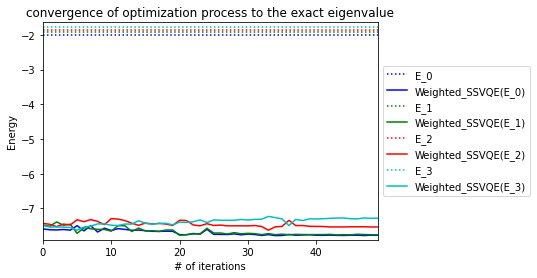

In [155]:
TI_approximated_energies = {'approximated_eneriges_0': [-7.589752024122858, -7.613360553742977, -7.6190283377699295, -7.606452381315795, -7.623841264856606, -7.494521829539001, -7.646521400209204, -7.497441846730476, -7.679252378794595, -7.568306667439035, -7.635326747625471, -7.581974996633829, -7.6029476683468165, -7.629264364655602, -7.622068391999914, -7.639909424564434, -7.658080921293223, -7.6610216888186935, -7.654527411413256, -7.66008477955216, -7.7547150031040335, -7.7564360961248395, -7.7211692300067325, -7.740308604020784, -7.600566578864045, -7.745346804765525, -7.7462796221068615, -7.751641127972047, -7.731226373852388, -7.759764904228919, -7.738323394248081, -7.75008559994191, -7.776677950424584, -7.753426121197687, -7.782341273752688, -7.779205848396213, -7.748582934815819, -7.770913423670053, -7.762781290918378, -7.757243053876988, -7.771747073785976, -7.77460241775567, -7.768169945808579, -7.775293924988296, -7.777833875967182, -7.772874566073456, -7.770639259052609, -7.780183175053531, -7.770198633263086, -7.772715721535181], 'approximated_eneriges_1': [-7.479491405676765, -7.511836148005719, -7.386839072151142, -7.482910503302419, -7.45350504578557, -7.717645422348506, -7.557130209537956, -7.585292224236378, -7.601455267806437, -7.6053728445146245, -7.652940774863644, -7.495571799306382, -7.498805036929139, -7.665075417141012, -7.564424290629817, -7.649242137492966, -7.63973609380236, -7.662321437170673, -7.6197253632972295, -7.619795999950689, -7.77220111836819, -7.7560901206803, -7.733399518265041, -7.731248976846906, -7.5715275315884965, -7.707440626139587, -7.707393893999951, -7.7348112389201, -7.6963929548826515, -7.7303082911355006, -7.716146462527111, -7.726011057644771, -7.754736352832551, -7.7244308215718, -7.755435989771994, -7.740311979126285, -7.75802286075666, -7.74587377621213, -7.7511355458410875, -7.7524697184268225, -7.752276487330399, -7.752209127687969, -7.745506448113101, -7.763323596450217, -7.753689897688524, -7.761008277453863, -7.742591039142208, -7.750704035603405, -7.754889646373152, -7.762317652046046], 'approximated_eneriges_2': [-7.429773687068325, -7.456290835401122, -7.5244382722139695, -7.449488807771006, -7.475902887301357, -7.323710694006624, -7.382629223743793, -7.319565894330178, -7.37324196562631, -7.4655637009696845, -7.292361426064088, -7.305355248566785, -7.349061659711274, -7.423506442892262, -7.487123730123055, -7.419043739762055, -7.4468612412996995, -7.429270866973703, -7.449287078710123, -7.488601777023326, -7.338899993772503, -7.3479680423849905, -7.4752168162071655, -7.499949509399753, -7.438503219564106, -7.490451691757577, -7.478437506558136, -7.500437702418609, -7.500581801475034, -7.499075900701008, -7.502121265617482, -7.491113049098129, -7.518867376724795, -7.626022727858267, -7.528977849213658, -7.51704786926269, -7.341426863319758, -7.492808200100214, -7.491951333497299, -7.513636940451013, -7.517112352002725, -7.519479170352952, -7.532633970484797, -7.531363773844777, -7.533977320554524, -7.527126270896771, -7.527817041278419, -7.526558961818585, -7.533610800208856, -7.53189647381379], 'approximated_eneriges_3': [-7.491338578949814, -7.5365715669859465, -7.532419245094768, -7.536703941979599, -7.547853449746403, -7.624626489025748, -7.534978590313114, -7.508989186601839, -7.445225566309921, -7.443181538165437, -7.482755392167175, -7.491627334989187, -7.448561403824932, -7.450744878426274, -7.3527159389057335, -7.429044714148724, -7.453107440745492, -7.43199903518407, -7.426905138160319, -7.471734210770166, -7.394515983381335, -7.402658524799258, -7.382535100794421, -7.3287228122787855, -7.4052951836113845, -7.3303577854783635, -7.339337904181725, -7.340771690542788, -7.340357772707655, -7.316555819042501, -7.333550487910194, -7.313936474027675, -7.31041466499232, -7.227826572283069, -7.263505884929646, -7.299661733764759, -7.4931242665258, -7.314755252756475, -7.3482236593292924, -7.29989242094733, -7.3017643952015465, -7.296684067035896, -7.284748556671026, -7.276492262521696, -7.272782406124991, -7.295223632281355, -7.3008113357190965, -7.27265620287829, -7.284622446048762, -7.278514057888236]}
plot_convergence_of_optimization_process(TI_approximated_energies, transverse_ising_4_qubits, )